# logistic regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Input and process data
## 1.1. Load data

In [3]:
column_names = [
    "erythema", "scaling", "definite borders", "itching", "koebner phenomenon",
    "polygonal papules", "follicular papules", "oral mucosal involvement", "knee and elbow involvement",
    "scalp involvement", "family history", "melanin incontinence", "eosinophils in the infiltrate",
    "PNL infiltrate", "fibrosis of the papillary dermis", "exocytosis", "acanthosis",
    "hyperkeratosis", "parakeratosis", "clubbing of the rete ridges", "elongation of the rete ridges",
    "thinning of the suprapapillary epidermis", "spongiform pustule", "munro microabcess",
    "focal hypergranulosis", "disappearance of the granular layer", "vacuolisation and damage of basal layer",
    "spongiosis", "saw-tooth appearance of retes", "follicular horn plug", "perifollicular parakeratosis",
    "inflammatory monoluclear inflitrate", "band-like infiltrate", "Age", "class"
]

dermatology_data = pd.read_csv('dermatology/dermatology.data', header=None, names=column_names)

## 1.2. Preprocess data
- I will replace the missing values with the median value of the column.
- Also I found that the colum "perifollicular parakeratosis" has only one value, so I will drop it.
- Due to the logistic regression, I will delete class 6,5,4,2

In [4]:
dermatology_data.replace("?", pd.NA, inplace=True)
dermatology_data['Age'] = pd.to_numeric(dermatology_data['Age'], errors='coerce')

# Fill the missing values in 'Age' with the median age
age_median = dermatology_data['Age'].median()
dermatology_data['Age'].fillna(age_median, inplace=True)

# delete class 6,5,4,2
dermatology_data = dermatology_data[dermatology_data['class'] != 6]
dermatology_data = dermatology_data[dermatology_data['class'] != 5]
dermatology_data = dermatology_data[dermatology_data['class'] != 4]
dermatology_data = dermatology_data[dermatology_data['class'] != 2]

dermatology_data.drop('perifollicular parakeratosis', axis=1, inplace=True)

dermatology_data.replace(3, 0, inplace=True)

## 1.3. Scale data
- I will scale the data using the min-max scaler.

In [5]:
dermatology_data_scaled = dermatology_data.copy()
for column in dermatology_data.columns[:-1]:
    col_min = dermatology_data[column].min()
    col_max = dermatology_data[column].max()
    dermatology_data_scaled[column] = (dermatology_data[column] - col_min) / (col_max - col_min)

# 1.4. Split data
- I will split the data into training and testing sets.

In [6]:
X = dermatology_data_scaled.drop('class', axis=1).values
y = dermatology_data_scaled['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Logistic Regression
## 2.1 Tools preparation
- I will define the sigmoid function.

In [7]:
def sigmoid(z):
    """
    To compute the sigmoid function for the input x
    :param z: the input data
    :return: the sigmoid function for the input x
    """
    return 1 / (1 + np.exp(-z))

## 2.2. Model preparation

In [8]:
class LogisticRegressionModel:
    """
    Logistic Regression Model
    :param learning_rate: the learning rate
    :param num_iterations: the number of iterations
    :param w: the weights
    :param b: the bias
    :param cost_history: the cost history will be used to plot the cost history
    """
    def __init__(self, learning_rate, num_iterations):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.b = None
        self.cost_history = []

    def compute_cost(self, X, y):
        """
        To compute the cost function
        :param X: the input data
        :param y: the labels
        :return: the cost of the model
        """
        m = len(y)
        h = sigmoid(np.dot(X, self.w) + self.b)
        epsilon = 1e-5  # Adding epsilon to avoid log(0)
        cost = (-1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
        return cost

    def compute_gradient(self, X, y):
        """
        To compute the gradient of the cost function
        :param X: the input data
        :param y: the labels
        :return: the gradient of the cost function
        """
        m = len(y)
        h = sigmoid(np.dot(X, self.w) + self.b)
        gradient_w = np.dot(X.T, (h - y)) / m
        gradient_b = np.sum(h - y) / m
        return gradient_w, gradient_b

    def fit(self, X, y):
        """
        To train the model, this function will update the weights and the bias and save the cost history.
        :param X: the input data
        :param y: the labels
        """
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for i in range(self.num_iterations):
            gradient_w, gradient_b = self.compute_gradient(X, y)
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)
            if i % 1000 == 0:
                print(f"Iteration {i+1}/{self.num_iterations} - Cost: {cost}")

    def predict_prob(self, X):
        """
        To predict the probability of the input data
        :param X: the input data
        :return: the probability of the input data
        """
        return sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X):
        """
        due to the logistic regression, I will predict the labels using the probability, so I use this function to convert the probability to the labels - 0 or 1.
        :param X: the input data
        :return: the labels of the input data which are 0 or 1
        """
        return [1 if x >= 0.5 else 0 for x in self.predict_prob(X)]

    def get_cost_history(self):
        """
        To get the cost history
        :return: the cost history
        """
        return self.cost_history


# 3. Train the model
- I will train the model using the training set.

In [9]:
model = LogisticRegressionModel(learning_rate=0.01, num_iterations=10000)

# Train the model
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)

Iteration 1/10000 - Cost: 0.6895464219688847
Iteration 1001/10000 - Cost: 0.11116935918857435
Iteration 2001/10000 - Cost: 0.06639644987002252
Iteration 3001/10000 - Cost: 0.04944639678025611
Iteration 4001/10000 - Cost: 0.04025366852351063
Iteration 5001/10000 - Cost: 0.034368283112996806
Iteration 6001/10000 - Cost: 0.030220581649898926
Iteration 7001/10000 - Cost: 0.02710891407528
Iteration 8001/10000 - Cost: 0.024669897453380746
Iteration 9001/10000 - Cost: 0.0226952792049568


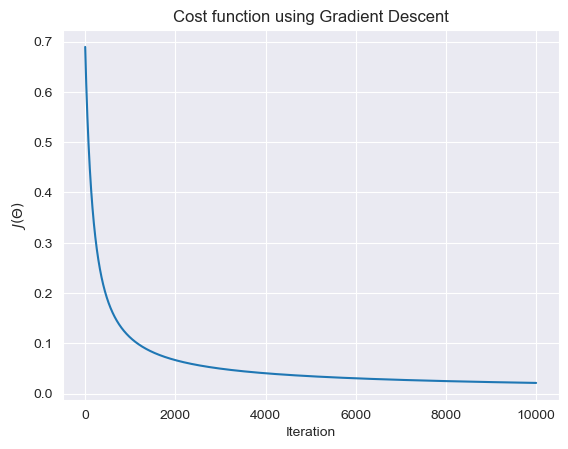

In [10]:
# Plot the cost history 
plt.plot(model.get_cost_history())
plt.xlabel('Iteration')
plt.ylabel('$J(\Theta)$')
plt.title('Cost function using Gradient Descent')
plt.show()

# 4. Evaluate the model
## 4.1. Accuracy
I will calculate the accuracy of the model.
Accuracy is calculated as follows:
$$\( \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} \times 100 \) $$
Where:
- $\( \text{Number of correct predictions} \)$ is the number of correct predictions.
- $\( \text{Total number of predictions} \)$ is the number of all predictions.
- $\( \text{Accuracy} \)$ is the accuracy of the model.
- I will use the function below to calculate the accuracy of the model.

In [11]:
def accuracy(y_true, y_pred):
    """
    To calculate the accuracy of the model
    :param y_true: the true labels
    :param y_pred: the predicted labels
    """
    correct = 0  
    for i in range(len(y_true)):  
        if y_true[i] == y_pred[i]: 
            correct += 1 
            
    result = correct / len(y_true) * 100
    print(f"Accuracy: {result:.2f}%")

accuracy(y_test, predictions_test)

Accuracy: 97.30%


## 4.2. MSE
MSE (Mean Squared Error) is calculated as follows:
$$
\[ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.

In [12]:
def mse(y_true, y_pred):
    """
    To calculate the mean squared error of the model
    :param y_true: the true labels
    :param y_pred: the predicted labels
    """
    return np.mean((y_true - y_pred) ** 2)

print(f"MSE: {mse(y_test, predictions_test)}")

MSE: 0.02702702702702703


## 4.3. Results visualization

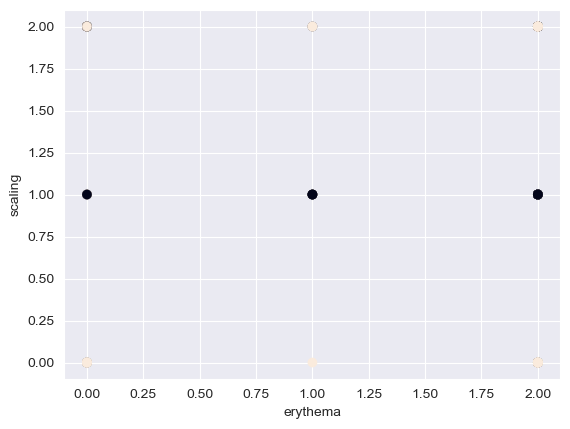

In [13]:
# Plot the erythema and scaling
plt.scatter(dermatology_data['erythema'], dermatology_data['scaling'], c=dermatology_data['class'])
plt.xlabel('erythema')
plt.ylabel('scaling')

plt.show()

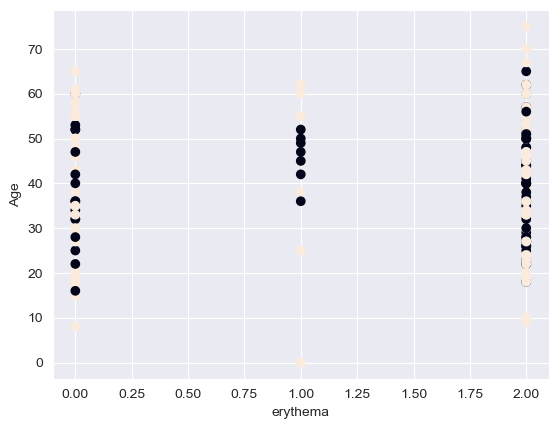

In [14]:
# Plot the koebner phenomenon and scaling
plt.scatter(dermatology_data['erythema'], dermatology_data['Age'], c=dermatology_data['class'])
plt.xlabel('erythema')
plt.ylabel('Age')

plt.show()